<a href="https://colab.research.google.com/github/Idybaz/Topic-Modelling/blob/main/TM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Python Libraries and Packages**

In [2]:
#Install the required libraries
!pip install contractions
!pip install nltk
!pip install gensim
!pip install pyldavis
!pip install SpaCy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 12.9 MB/s eta 0:00:00


In [3]:
# Import the required libraries
import contractions
import string
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from collections import Counter
import gensim
from gensim.models import TfidfModel
from gensim.models import LdaModel
import gensim.corpora as corpora
from gensim.models import CoherenceModel
from gensim.models import Phrases
from gensim.models.phrases import Phraser
import spacy
import pyLDAvis
import pyLDAvis.gensim_models
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Ensure necessary NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

# **Load the Data**

In [5]:
# Define Function to Load the Data
def load_and_explore_data(filepath):
    df = pd.read_csv(filepath)
    print("Data loaded successfully.")
    return df

# Load the data
filepath = "/content/drive/MyDrive/CNN_Articels_clean.csv"
dataset = load_and_explore_data(filepath)

Data loaded successfully.


# **Exploratory Data Analysis**

Display DataSet

In [6]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
dataset.head()

First few rows of the dataset:


,Index,Author,Date published,Category,Section,Url,Headline,Description,Keywords,Second headline,Article text
0,0,"Jacopo Prisco, CNN",2021-07-15 02:46:59,news,world,https://www.cnn.com/2021/07/14/world/tusimple-...,"There's a shortage of truckers, but TuSimple t...",The e-commerce boom has exacerbated a global t...,"world, There's a shortage of truckers, but TuS...","There's a shortage of truckers, but TuSimple t...","(CNN)Right now, there's a shortage of truck d..."
1,1,"Stephanie Bailey, CNN",2021-05-12 07:52:09,news,world,https://www.cnn.com/2021/05/12/world/ironhand-...,Bioservo's robotic 'Ironhand' could protect fa...,Working in a factory can mean doing the same t...,"world, Bioservo's robotic 'Ironhand' could pro...",A robotic 'Ironhand' could protect factory wor...,(CNN)Working in a factory or warehouse can me...
2,2,"Words by Stephanie Bailey, video by Zahra Jamshed",2021-06-16 02:51:30,news,asia,https://www.cnn.com/2021/06/15/asia/swarm-robo...,This swarm of robots gets smarter the more it ...,"In a Hong Kong warehouse, a swarm of autonomou...","asia, This swarm of robots gets smarter the mo...",This swarm of robots gets smarter the more it ...,"(CNN)In a Hong Kong warehouse, a swarm of aut..."
3,3,Kathryn Vasel,2022-03-18 14:37:21,business,success,https://www.cnn.com/2022/03/18/success/pandemi...,"Two years later, remote work has changed milli...",Here's a look at how the pandemic reshaped peo...,"success, Two years later, remote work has chan...","Two years later, remote work has changed milli...",The pandemic thrust the working world into a n...
4,4,"Paul R. La Monica, CNN Business",2022-03-19 11:41:08,business,investing,https://www.cnn.com/2022/03/19/investing/march...,Why March is so volatile for stocks - CNN,March Madness isn't just for college basketbal...,"investing, Why March is so volatile for stocks...",Why March is so volatile for stocks,New York (CNN Business)March Madness isn't jus...


DataSet Information

In [7]:
# Display basic information about the dataset
print("Dataset Info:")
dataset.info()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37949 entries, 0 to 37948
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Index            37949 non-null  int64 
 1   Author           37949 non-null  object
 2   Date published   37949 non-null  object
 3   Category         37949 non-null  object
 4   Section          37949 non-null  object
 5   Url              37949 non-null  object
 6   Headline         37949 non-null  object
 7   Description      37949 non-null  object
 8   Keywords         37949 non-null  object
 9   Second headline  37949 non-null  object
 10  Article text     37940 non-null  object
dtypes: int64(1), object(10)
memory usage: 3.2+ MB


Data Type Conversion   
The data were converted to their appropriate data type

In [8]:
# Define a dictionary to map column names to their desired data types
dtype_mapping = {
    'Author': 'string',
    'Date published': 'datetime64[ns]',
    'Category': 'category',
    'Section': 'category',
    'Url': 'string',
    'Headline': 'string',
    'Description': 'string',
    'Keywords': 'string',
    'Second headline': 'string',
    'Article text': 'string'
}

# Apply the data type conversions
for column, dtype in dtype_mapping.items():
    dataset[column] = dataset[column].astype(dtype)

# Display the data types to confirm
print(dataset.dtypes)

Index                       int64
Author             string[python]
Date published     datetime64[ns]
Category                 category
Section                  category
Url                string[python]
Headline           string[python]
Description        string[python]
Keywords           string[python]
Second headline    string[python]
Article text       string[python]
dtype: object


Handling Missing Values

In [9]:
#checks for missing values
missing_values = dataset.isnull().sum()
missing_values

Index              0
Author             0
Date published     0
Category           0
Section            0
Url                0
Headline           0
Description        0
Keywords           0
Second headline    0
Article text       9
dtype: int64

Dropping Missing Value Rows

In [10]:
# Drop rows with missing values in any column
dataset.dropna(how='any', inplace=True)

New Article Category View

In [11]:
# Analysing the Categories
print('Category:')
dataset.Category.unique()

Category:


['news', 'business', 'health', 'entertainment', 'sport', 'politics', 'travel', 'vr', 'style']
Categories (9, object): ['business', 'entertainment', 'health', 'news', ..., 'sport', 'style', 'travel',
                         'vr']

New Article Timeframe View

In [12]:
# Analyzing the date range
dataset['Date published'] = pd.to_datetime(dataset['Date published'])
date_range = dataset['Date published'].min(), dataset['Date published'].max()
date_range

(Timestamp('2011-08-24 17:54:07'), Timestamp('2022-03-21 11:40:28'))

Selecting Relevant Data for the Study

In [13]:
# Filter the dataset based on the given criteria
dataset_filtered = dataset.loc[
    (dataset['Date published'] >= '2020-01-01') &
    (dataset['Date published'] <= '2023-03-21') &
    (dataset['Category'].isin(['politics', 'news', 'business']))
]

# Select only the relevant columns
data = dataset_filtered[['Article text', 'Category', 'Date published']]

# Get the number of entries in this filtered dataset
num_entries = dataset_filtered.shape[0]

print(f"Number of entries from 2020 to 2022: {num_entries}")

# Display the first few rows of the filtered dataset
data.head()

Number of entries from 2020 to 2022: 8081


,Article text,Category,Date published
0,"(CNN)Right now, there's a shortage of truck d...",news,2021-07-15 02:46:59
1,(CNN)Working in a factory or warehouse can me...,news,2021-05-12 07:52:09
2,"(CNN)In a Hong Kong warehouse, a swarm of aut...",news,2021-06-16 02:51:30
3,The pandemic thrust the working world into a n...,business,2022-03-18 14:37:21
4,New York (CNN Business)March Madness isn't jus...,business,2022-03-19 11:41:08


Distribution of Selceted Articles Over Time

<ipython-input-14-fffb8a54cd3c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'Year'] = data['Date published'].dt.year


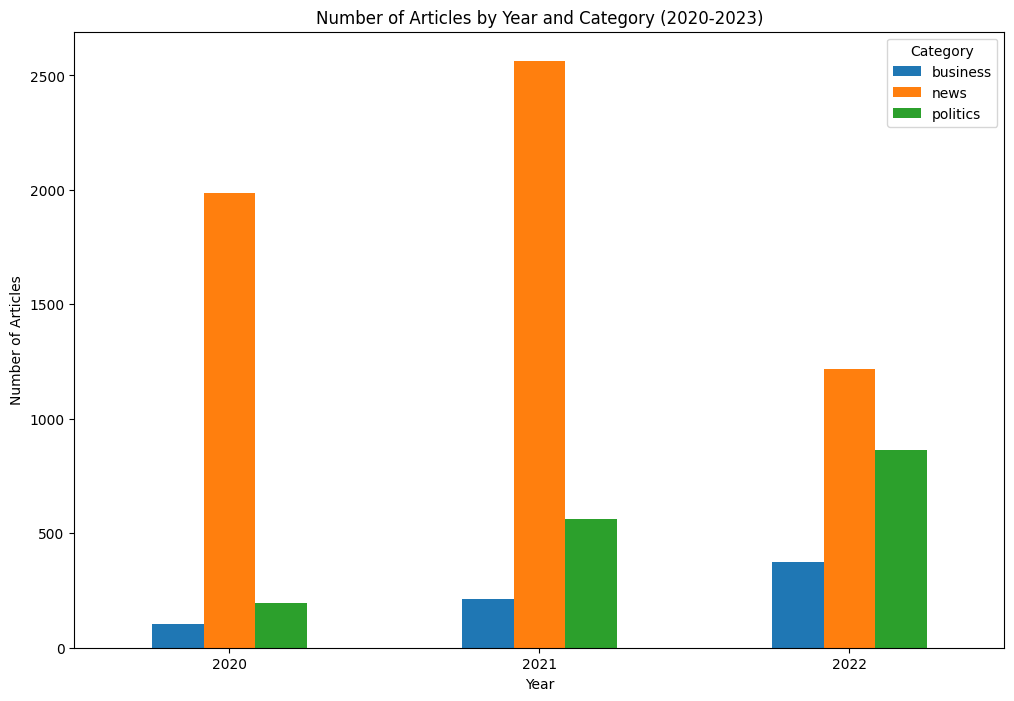

In [14]:
# Extract the year from the 'Date published' column
data.loc[:,'Year'] = data['Date published'].dt.year

# Group the data by year and category
grouped_data = data.groupby(['Year', 'Category'], observed=True).size().unstack().fillna(0)

# Drop categories with zero frequency
grouped_data = grouped_data.loc[:, (grouped_data != 0).any(axis=0)]

# Plot the number of articles for each year and category
grouped_data.plot(kind='bar', stacked=False, figsize=(12, 8))
plt.title('Number of Articles by Year and Category (2020-2023)')
plt.xlabel('Year')
plt.ylabel('Number of Articles')
plt.xticks(rotation=0)
plt.legend(title='Category')
plt.show()

# **Data Preprocessing**

Original Text

In [15]:
# Total words in Original Article Text
original_word_count = data['Article text'].str.split().str.len().sum()
print(f"Total words in original text: {original_word_count}")

# Display the first 150 characters of the first article text
print(f"First article text: {data['Article text'].iloc[0]}")

Total words in original text: 8214570
First article text:  (CNN)Right now, there's a shortage of truck drivers in the US and worldwide, exacerbated by the e-commerce boom brought on by the pandemic. One solution to the problem is autonomous trucks, and several companies are in a race to be the first to launch one. Among them is San Diego-based TuSimple.Founded in 2015, TuSimple has completed about 2 million miles of road tests with its 70 prototype trucks across the US, China and Europe. Although these are simply commercially available trucks retrofitted with its technology, TuSimple has deals in place with two of the world's largest truck manufacturers -- Navistar in the US and Traton, Volkswagen's trucking business, in Europe -- to design and build fully autonomous models, which it hopes to launch by 2024. Photos: The Yara Birkeland is what its builders call the world's first zero-emission, autonomous cargo ship. The ship is scheduled to make its first journey between two Norwegian t

Cleaning Text

In [16]:
# Preprocessing function
def preprocess_text(text):
    text = contractions.fix(text)  # Expand contractions
    text = re.sub(r'\(.*?\)', '', text)  # Remove text in parentheses
    text = re.sub(r'\bcnn\b', '', text, flags=re.IGNORECASE)  # Remove CNN mentions
    text = re.sub(r'Hide Caption.*?Photos:', '', text)  # Remove captions and boilerplate
    text = re.sub(r'Read More', '', text)  # Remove "Read More" boilerplate
    text = text.lower()  # Lowercase the text
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove non-alphanumeric characters
    return text


# Apply preprocessing
data['Cleaned Article Text'] = data['Article text'].apply(preprocess_text)
print (f"Cleaned article text: {data['Cleaned Article Text'].iloc[0]}")

Cleaned article text:  right now there is a shortage of truck drivers in the us and worldwide exacerbated by the ecommerce boom brought on by the pandemic one solution to the problem is autonomous trucks and several companies are in a race to be the first to launch one among them is san diegobased tusimplefounded in  tusimple has completed about  million miles of road tests with its  prototype trucks across the us china and europe although these are simply commercially available trucks retrofitted with its technology tusimple has deals in place with two of the worlds largest truck manufacturers navistar in the us and traton volkswagens trucking business in europe to design and build fully autonomous models which it hopes to launch by  photos the yara birkeland is what its builders call the worlds first zeroemission autonomous cargo ship the ship is scheduled to make its first journey between two norwegian towns before the end of the year click through to see more forms of transport set

<ipython-input-16-e0e669d38246>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cleaned Article Text'] = data['Article text'].apply(preprocess_text)


In [17]:
# Cleaned Article Text
cleaned_word_count = data['Cleaned Article Text'].str.split().str.len().sum()
print(f"Total words after preprocessing: {cleaned_word_count}")


Total words after preprocessing: 7944007


Removing Stopwords

In [18]:
# Define stopwords, including custom ones
stop_words = set(stopwords.words('english'))

# Removing Stop Words
def remove_stopwords(text, stop_words):
    return " ".join([word for word in text.split() if word not in stop_words])

data['Cleaned Article Text'] = data['Cleaned Article Text'].apply(lambda x: remove_stopwords(x, stop_words))
print (f"Stopwords removed article text: {data['Cleaned Article Text'].iloc[0]}")

Stopwords removed article text: right shortage truck drivers us worldwide exacerbated ecommerce boom brought pandemic one solution problem autonomous trucks several companies race first launch one among san diegobased tusimplefounded tusimple completed million miles road tests prototype trucks across us china europe although simply commercially available trucks retrofitted technology tusimple deals place two worlds largest truck manufacturers navistar us traton volkswagens trucking business europe design build fully autonomous models hopes launch photos yara birkeland builders call worlds first zeroemission autonomous cargo ship ship scheduled make first journey two norwegian towns end year click see forms transport set transform future pictured rendering oceanbird windpowered transatlantic car carrier cuts carbon emissions compared standard car carrier maritime ships going green cities around world adopting electric ferries norwegian startup zeabuz hopes selfdriving electric ferry hel

<ipython-input-18-db6b0b5ddff3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cleaned Article Text'] = data['Cleaned Article Text'].apply(lambda x: remove_stopwords(x, stop_words))


In [19]:
# Total words After Removing Stop Words
stopwords_removed_word_count = data['Cleaned Article Text'].apply(lambda x: remove_stopwords(x, stop_words)).str.split().str.len().sum()
print(f"Total words after removing stop words: {stopwords_removed_word_count}")

Total words after removing stop words: 4555951


In [20]:
# Combine all cleaned text into a single string
all_cleaned_text = ' '.join(data['Cleaned Article Text'].tolist())

# Split the cleaned text into words
words = all_cleaned_text.split()

# Get the top 20 most frequent words
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Display the top 20 most frequent words
print("\nTop 20 most frequent words:")
for word, count in most_common_words:
    print(f"{word}: {count}")


Top 20 most frequent words:
said: 49883
people: 20718
us: 18736
would: 17891
new: 16232
coronavirus: 15698
one: 15321
also: 15300
president: 11789
told: 11779
could: 11770
according: 11037
first: 10452
russia: 10218
time: 10203
state: 10105
police: 9894
last: 9430
trump: 9392
two: 9315


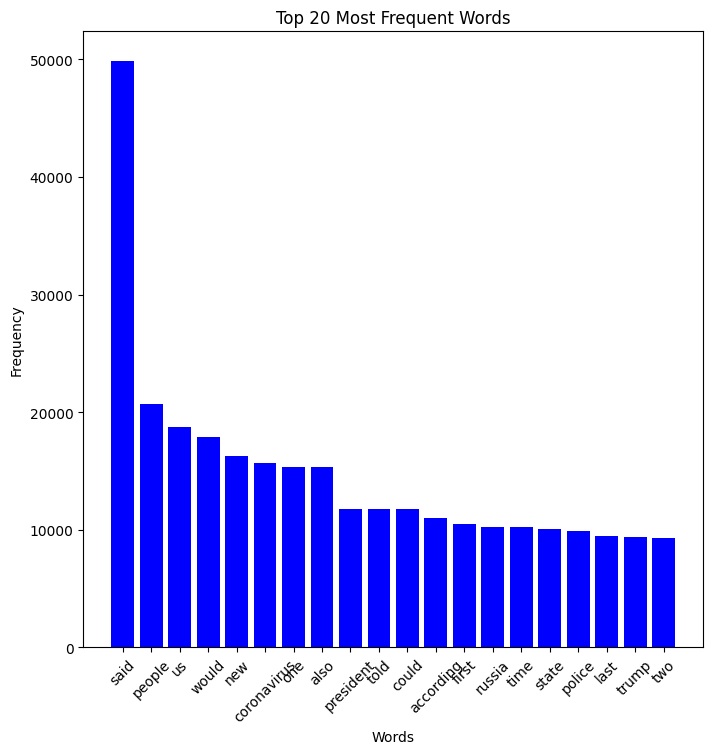

In [21]:
# Create a bar chart for the top 20 most frequent words
words, counts = zip(*most_common_words)
plt.figure(figsize=(8, 8))
plt.bar(words, counts, color='blue')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

In [22]:
# Define custom stopwords
custom_stop_words = {'said', 'could', 'would', 'also', 'people', 'told', 'go', 'say', 'time', 'get', 'make', 'see', 'want', 'year', 'think', 'take', 'know', 'come', 'even', 'work', 'back', 'way', 'live', 'feel', 'thing', 'give', 'look', 'much', 'day', 'still', 'first', 'good', 'happen', 'long', 'well', 'need', 'new'}
stop_words.update(custom_stop_words)

# Removing Stop Words including the custom ones
def remove_stopwords(text, stop_words):
    return " ".join([word for word in text.split() if word not in stop_words])

data['Cleaned Article Text'] = data['Cleaned Article Text'].apply(lambda x: remove_stopwords(x, stop_words))
print(f"Custom stopwords removed article text: {data['Cleaned Article Text'].iloc[0]}")



Custom stopwords removed article text: right shortage truck drivers us worldwide exacerbated ecommerce boom brought pandemic one solution problem autonomous trucks several companies race launch one among san diegobased tusimplefounded tusimple completed million miles road tests prototype trucks across us china europe although simply commercially available trucks retrofitted technology tusimple deals place two worlds largest truck manufacturers navistar us traton volkswagens trucking business europe design build fully autonomous models hopes launch photos yara birkeland builders call worlds zeroemission autonomous cargo ship ship scheduled journey two norwegian towns end click forms transport set transform future pictured rendering oceanbird windpowered transatlantic car carrier cuts carbon emissions compared standard car carrier maritime ships going green cities around world adopting electric ferries norwegian startup zeabuz hopes selfdriving electric ferry help revive urban waterways 

<ipython-input-22-f70fb7184a85>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Cleaned Article Text'] = data['Cleaned Article Text'].apply(lambda x: remove_stopwords(x, stop_words))


In [23]:
# Total words After Custom Stop Words Removal
custom_stopwords_removed_word_count = data['Cleaned Article Text'].apply(lambda x: remove_stopwords(x, custom_stop_words)).str.split().str.len().sum()
print(f"Total words after removing custom stop words: {custom_stopwords_removed_word_count}")

Total words after removing custom stop words: 4270725


In [24]:
# Combine all cleaned text into a single string after removing stop words
all_cleaned_text = ' '.join(data['Cleaned Article Text'].tolist())

# Split the cleaned text into words
words = all_cleaned_text.split()

# Get the new top 20 most frequent words after removing stop words
word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

# Display the new top 20 most frequent words
print("\nNew Top 20 most frequent words after removing stop words:")
for word, count in most_common_words:
    print(f"{word}: {count}")


New Top 20 most frequent words after removing stop words:
us: 18736
coronavirus: 15698
one: 15321
president: 11789
according: 11037
russia: 10218
state: 10105
police: 9894
last: 9430
trump: 9392
two: 9315
covid: 8969
like: 8921
years: 8606
government: 8460
many: 8456
russian: 7808
house: 7602
country: 7593
may: 7507


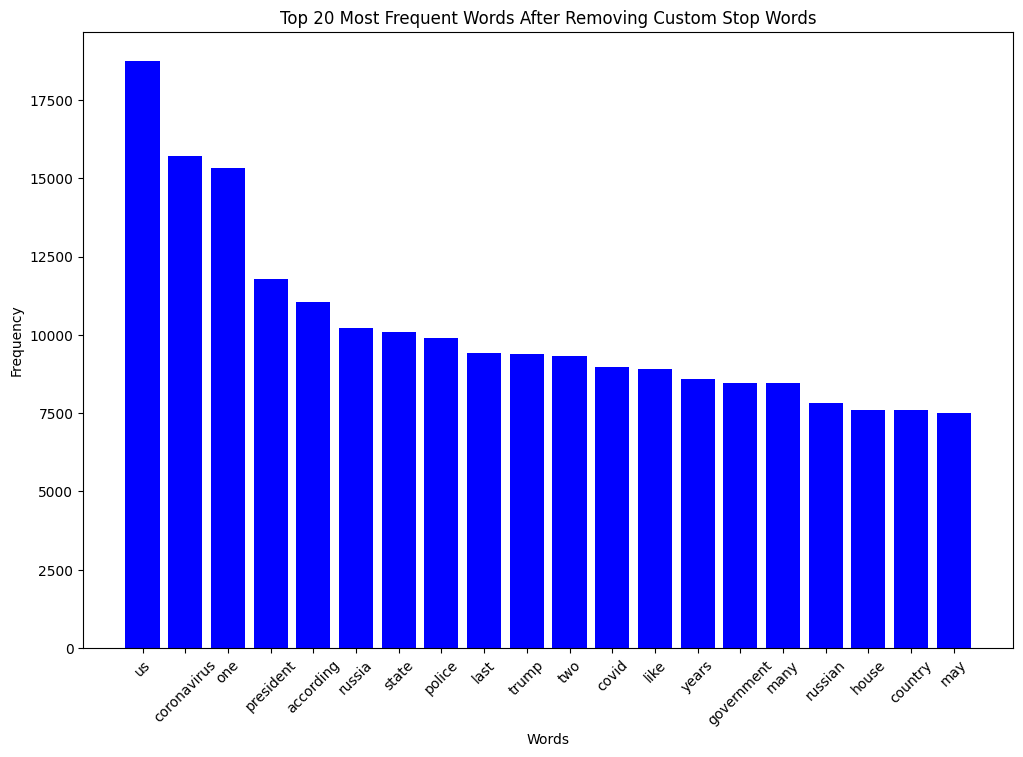

In [25]:
# Create a bar chart for the new top 20 most frequent words
words, counts = zip(*most_common_words)
plt.figure(figsize=(12, 8))
plt.bar(words, counts, color='blue')
plt.title('Top 20 Most Frequent Words After Removing Custom Stop Words')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

Stemming

In [26]:
# Stemming
def stemming(texts):
    """Stem the texts using NLTK's PorterStemmer"""
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in text.split()]) for text in texts]

# Apply stemming to cleaned texts
stemmed_texts = stemming(data['Cleaned Article Text'])
print(f"Stemmed Texts: {stemmed_texts[0]}")

Stemmed Texts: right shortag truck driver us worldwid exacerb ecommerc boom brought pandem one solut problem autonom truck sever compani race launch one among san diegobas tusimplefound tusimpl complet million mile road test prototyp truck across us china europ although simpli commerci avail truck retrofit technolog tusimpl deal place two world largest truck manufactur navistar us traton volkswagen truck busi europ design build fulli autonom model hope launch photo yara birkeland builder call world zeroemiss autonom cargo ship ship schedul journey two norwegian town end click form transport set transform futur pictur render oceanbird windpow transatlant car carrier cut carbon emiss compar standard car carrier maritim ship go green citi around world adopt electr ferri norwegian startup zeabuz hope selfdriv electr ferri help reviv urban waterway china maglev highspe train roll product line qingdao east china shandong provinc juli top speed km per hour current fastest ground vehicl avail 

In [27]:
# Total words after stemming
stemmed_word_count = pd.Series(stemmed_texts).str.split().str.len().sum()
print(f"Total words after stemming: {stemmed_word_count}")

Total words after stemming: 4270725


Lemmatization

In [28]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Lemmatize the texts using spacy, keeping only specified part-of-speech tags"""
    nlp= spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    texts_out = []
    for text in texts:
        doc = nlp(text)
        new_text = []
        for token in doc:
          if token.pos_ in allowed_postags:
             new_text.append(token.lemma_ )
        final = " ".join(new_text)
        texts_out.append(final)
    return (texts_out)

In [29]:
# Apply Lemmatization to cleaned text
# cleaned_text = data['Cleaned Article Text']
lemmatized_texts = lemmatization(stemmed_texts)
print (f"Lemmatized Texts: {lemmatized_texts[0]}")

Lemmatized Texts: right shortag truck driver worldwid exacerb boom bring solut problem truck sever compani race launch tusimpl mile road test prototyp truck commerci avail truck retrofit technolog tusimpl deal place world large truck manufactur navistar truck busi europ design builder call world ship ship schedul journey norwegian town end click form transport set transform futur pictur render transatlant car carrier standard car carrier ship go green world adopt electr startup roll product line top speed km hour current fast ground vehicl speed kilomet hour hyperloop sustain replac flight start hyperloop test facil europ open hyperloop bullet train track rail float tube use low carbon travel switch sustain fuel sourc redesign plane design delft univer technolog cut fuel kerosen sustain fuel sourc liquid hydrogen sustain solut short flight septemb plan hydrogenpow aircraft decemb canadian fly harbour half annual case electr bike retail report sale pedal allow less effort train buse shu

In [30]:
# Total words After Lemmatization
lemmatized_word_count = pd.Series(lemmatized_texts).str.split().str.len().sum()
print(f"Total words after lemmatization: {lemmatized_word_count}")

Total words after lemmatization: 2338949


Tokenization

In [31]:
# Tokenization function
def tokenize(texts):
    return [text.split() for text in texts]

# Apply tokenization to the lemmatized texts
data_words = tokenize(lemmatized_texts)
print (f"Tokenized Texts: {data_words[0]}")

Tokenized Texts: ['right', 'shortag', 'truck', 'driver', 'worldwid', 'exacerb', 'boom', 'bring', 'solut', 'problem', 'truck', 'sever', 'compani', 'race', 'launch', 'tusimpl', 'mile', 'road', 'test', 'prototyp', 'truck', 'commerci', 'avail', 'truck', 'retrofit', 'technolog', 'tusimpl', 'deal', 'place', 'world', 'large', 'truck', 'manufactur', 'navistar', 'truck', 'busi', 'europ', 'design', 'builder', 'call', 'world', 'ship', 'ship', 'schedul', 'journey', 'norwegian', 'town', 'end', 'click', 'form', 'transport', 'set', 'transform', 'futur', 'pictur', 'render', 'transatlant', 'car', 'carrier', 'standard', 'car', 'carrier', 'ship', 'go', 'green', 'world', 'adopt', 'electr', 'startup', 'roll', 'product', 'line', 'top', 'speed', 'km', 'hour', 'current', 'fast', 'ground', 'vehicl', 'speed', 'kilomet', 'hour', 'hyperloop', 'sustain', 'replac', 'flight', 'start', 'hyperloop', 'test', 'facil', 'europ', 'open', 'hyperloop', 'bullet', 'train', 'track', 'rail', 'float', 'tube', 'use', 'low', 'carbo

Generating Bigrams and Trigrams

In [32]:
# Build the bigram and trigram models
bigram_phrases = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram_phrases = gensim.models.Phrases(bigram_phrases[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram = gensim.models.phrases.Phraser(bigram_phrases)
trigram_mod = gensim.models.phrases.Phraser(trigram_phrases)

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram[doc]] for doc in texts]

# Form Bigrams and Trigrams
data_bigrams = make_bigrams(data_words)
data_bigrams_trigrams = make_trigrams(data_words)

print (f"n-gram Token: {data_bigrams_trigrams[0]}")

n-gram Token: ['right', 'shortag', 'truck_driver', 'worldwid', 'exacerb', 'boom', 'bring', 'solut', 'problem', 'truck', 'sever', 'compani', 'race', 'launch', 'tusimpl', 'mile', 'road', 'test', 'prototyp', 'truck', 'commerci', 'avail', 'truck', 'retrofit', 'technolog', 'tusimpl', 'deal', 'place', 'world', 'large', 'truck', 'manufactur', 'navistar', 'truck', 'busi', 'europ', 'design', 'builder', 'call', 'world', 'ship', 'ship', 'schedul', 'journey', 'norwegian', 'town', 'end', 'click', 'form', 'transport', 'set', 'transform', 'futur', 'pictur', 'render', 'transatlant', 'car', 'carrier', 'standard', 'car', 'carrier', 'ship', 'go', 'green', 'world', 'adopt', 'electr', 'startup', 'roll', 'product', 'line', 'top', 'speed', 'km', 'hour', 'current', 'fast', 'ground', 'vehicl', 'speed', 'kilomet', 'hour', 'hyperloop', 'sustain', 'replac', 'flight', 'start', 'hyperloop', 'test', 'facil', 'europ', 'open', 'hyperloop', 'bullet', 'train', 'track', 'rail', 'float', 'tube', 'use', 'low', 'carbon', 't

In [33]:
# Calculate the total word count after forming bigrams and trigrams
total_word_count = sum(len(doc) for doc in data_bigrams_trigrams)

print(f"Total word count after forming bigrams and trigrams: {total_word_count}")

Total word count after forming bigrams and trigrams: 2261069


# **LDA Model Building**


Creating the Dictionary

In [34]:
# Generate a dictionary mapping from word IDs to words
id2word = corpora.Dictionary(data_bigrams_trigrams)

# Filter out words that occur in less than 2 documents or more than 97% of the documents
id2word.filter_extremes(no_below=2, no_above=0.97)
print('Total Vocabulary Size:', len(id2word))

Total Vocabulary Size: 25636


Text Representation using both BoW

In [35]:
# Create the Bag-of-Words (BoW) corpus
texts = data_bigrams_trigrams
corpus = [id2word.doc2bow(text) for text in texts]
# Print the BoW representation of the first document
print("Bag-of-Words representation of the first document:")
print(corpus[0])

Bag-of-Words representation of the first document:
[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 2), (7, 2), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 3), (28, 1), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 2), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 5), (50, 2), (51, 1), (52, 1), (53, 1), (54, 1), (55, 2), (56, 1), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 3), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 3), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 2), (104, 3), (105, 1)

Text Representation using both TF-IDF

In [36]:
# Create TF-IDF corpus
# Initialize the TF-IDF model
tfidf = TfidfModel(corpus)
# Transform the corpus to TF-IDF representation
corpus_tfidf = tfidf[corpus]
print("TF-IDF representation of the first document:")
print (corpus_tfidf[0])

TF-IDF representation of the first document:
[(0, 0.027225779379856475), (1, 0.033431964819762065), (2, 0.01701407382017103), (3, 0.031136790238605862), (4, 0.011654789290791405), (5, 0.029037998769592958), (6, 0.045979353416237045), (7, 0.09020817063244387), (8, 0.02248567846668115), (9, 0.016219127966515492), (10, 0.009547571721766233), (11, 0.022367870660135507), (12, 0.02377172954197681), (13, 0.04726984153020845), (14, 0.06122344320932481), (15, 0.038901786474812135), (16, 0.06122344320932481), (17, 0.011124574175944226), (18, 0.022222871374585028), (19, 0.026470978038222768), (20, 0.04980606240682601), (21, 0.03452057802258502), (22, 0.04429425836201677), (23, 0.02202394167451972), (24, 0.00703716081939005), (25, 0.059913663122985066), (26, 0.03387345383180613), (27, 0.05594795431040776), (28, 0.03628013736495431), (29, 0.07800955733662017), (30, 0.00866367748240164), (31, 0.016921127566843167), (32, 0.020243896427423403), (33, 0.021639531928620788), (34, 0.025413086136293856), (

# **LDA Model Training**

In [37]:
#  Build LDA models with BoW Features
lda_model_bow = LdaModel(corpus=corpus,
                         id2word=id2word,
                         num_topics=10,
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         eta= 'auto')

print("LDA Model (BoW) Topics:\n")
for idx, topic in lda_model_bow.print_topics(num_words=10):
    print(f"Topic {idx+1}: {topic}")


LDA Model (BoW) Topics:

Topic 1: 0.014*"countri" + 0.013*"use" + 0.011*"world" + 0.010*"europ" + 0.008*"australian" + 0.007*"climat" + 0.007*"year" + 0.006*"global" + 0.006*"research" + 0.006*"say"
Topic 2: 0.203*"royal" + 0.044*"queen" + 0.030*"duchess" + 0.029*"princess" + 0.029*"monarch" + 0.019*"duchess_sussex" + 0.014*"cell" + 0.014*"king" + 0.013*"camilla" + 0.012*"weekli_dispatch_bring"
Topic 3: 0.022*"vote" + 0.019*"presid" + 0.014*"former" + 0.013*"polit" + 0.013*"hous" + 0.013*"leader" + 0.011*"state" + 0.009*"support" + 0.009*"trump" + 0.009*"conserv"
Topic 4: 0.021*"govern" + 0.012*"countri" + 0.012*"report" + 0.010*"public" + 0.009*"statement" + 0.009*"state" + 0.007*"ad" + 0.007*"rule" + 0.007*"last" + 0.007*"group"
Topic 5: 0.036*"fire" + 0.018*"water" + 0.017*"area" + 0.016*"flood" + 0.013*"hous" + 0.010*"town" + 0.010*"burn" + 0.010*"home" + 0.009*"weather" + 0.009*"see"
Topic 6: 0.040*"russian" + 0.028*"ukrain" + 0.016*"ukrainian" + 0.013*"border" + 0.012*"countri" +

In [38]:
# Build LDA model with TF-IDF Features
lda_model_tfidf = LdaModel(corpus=corpus_tfidf,
                         id2word=id2word,
                         num_topics=10,
                         random_state=100,
                         update_every=1,
                         chunksize=100,
                         passes=10,
                         alpha='auto',
                         eta= 'auto')


print("\nLDA Model (TF-IDF) Topics:")
for idx, topic in lda_model_tfidf.print_topics(num_words=10):
    print(f"Topic {idx+1}: {topic}")


LDA Model (TF-IDF) Topics:
Topic 1: 0.013*"russian" + 0.008*"ukrain" + 0.007*"europ" + 0.006*"govern" + 0.005*"countri" + 0.005*"border" + 0.005*"german" + 0.005*"ad" + 0.005*"prime_minist" + 0.005*"minist"
Topic 2: 0.022*"royal" + 0.008*"italian" + 0.008*"doctor" + 0.007*"suffer" + 0.007*"dog" + 0.006*"anim" + 0.006*"daughter" + 0.006*"demonstr" + 0.005*"freedom" + 0.005*"love"
Topic 3: 0.010*"theater" + 0.009*"unit_kingdom" + 0.006*"commiss" + 0.006*"trust" + 0.006*"nur" + 0.006*"defen" + 0.006*"garden" + 0.006*"leadership" + 0.006*"premier" + 0.005*"diver"
Topic 4: 0.000*"kherson" + 0.000*"topdown" + 0.000*"arbor" + 0.000*"microchip" + 0.000*"saidauthor" + 0.000*"spreadth" + 0.000*"contactthi" + 0.000*"soth" + 0.000*"onemil" + 0.000*"worlda"
Topic 5: 0.000*"topdown" + 0.000*"worlda" + 0.000*"microchip" + 0.000*"saidauthor" + 0.000*"spreadth" + 0.000*"contactthi" + 0.000*"soth" + 0.000*"onemil" + 0.000*"testingi" + 0.000*"arbor"
Topic 6: 0.000*"topdown" + 0.000*"worlda" + 0.000*"mic

Coherence Scores for BoW

In [44]:
# Calculate C_V coherence for BoW model
coherence_model_bow_cv = CoherenceModel(model=lda_model_bow, texts=texts, dictionary=id2word, coherence='c_v')
coherence_bow_cv = coherence_model_bow_cv.get_coherence()
print(f'C_V Coherence Score (BoW): {coherence_bow_cv}')

# Calculate C_UCI coherence for BoW model
coherence_model_bow_c_uci = CoherenceModel(model=lda_model_bow, texts=texts, dictionary=id2word, coherence='c_uci')
coherence_bow_c_uci = coherence_model_bow_c_uci.get_coherence()
print(f'C_UCI Coherence Score (BoW): {coherence_bow_c_uci}')

# Calculate C_NPMI coherence for BoW model
coherence_model_bow_c_npmi = CoherenceModel(model=lda_model_bow, texts=texts, dictionary=id2word, coherence='c_npmi')
coherence_bow_c_npmi = coherence_model_bow_c_npmi.get_coherence()
print(f'C_NPMI Coherence Score (BoW): {coherence_bow_c_npmi}')

C_V Coherence Score (BoW): 0.48071267380209387
C_UCI Coherence Score (BoW): -0.4032905231005327
C_NPMI Coherence Score (BoW): 0.020050138138625752


Coherence Scores for TF-IDF

In [40]:
# Calculate C_V coherence for TF-IDF model
coherence_model_tfidf_cv = CoherenceModel(model=lda_model_tfidf, texts=texts, dictionary=id2word, coherence='c_v')
coherence_tfidf_cv = coherence_model_tfidf_cv.get_coherence()
print(f'C_V Coherence Score (TF-IDF): {coherence_tfidf_cv}')

# Calculate C_UCI coherence for TF-IDF model
coherence_model_tfidf_c_uci = CoherenceModel(model=lda_model_tfidf, texts=texts, dictionary=id2word, coherence='c_uci')
coherence_tfidf_c_uci = coherence_model_tfidf_c_uci.get_coherence()
print(f'C_UCI Coherence Score (TF-IDF): {coherence_tfidf_c_uci}')

# Calculate C_NPMI coherence for TF-IDF model
coherence_model_tfidf_c_npmi = CoherenceModel(model=lda_model_tfidf, texts=texts, dictionary=id2word, coherence='c_npmi')
coherence_tfidf_c_npmi = coherence_model_tfidf_c_npmi.get_coherence()
print(f'C_NPMI Coherence Score (TF-IDF): {coherence_tfidf_c_npmi}')


C_V Coherence Score (TF-IDF): 0.34596390102941466
C_UCI Coherence Score (TF-IDF): -4.286619381457177
C_NPMI Coherence Score (TF-IDF): -0.1486398395049952


Visualization of LDA topic Modeling

In [41]:
# Visualize the topics
# Enable notebook mode
pyLDAvis.enable_notebook()

# Prepare the visualization data for BoW model
lda_display_bow = pyLDAvis.gensim_models.prepare(lda_model_bow, corpus, id2word)

print("\nVisualizing BoW Model:")
pyLDAvis.display(lda_display_bow)


Visualizing BoW Model:


In [42]:
# Prepare the visualization data for TF-IDF model
lda_display_tfidf = pyLDAvis.gensim_models.prepare(lda_model_tfidf, corpus_tfidf, id2word)
print("\nVisualizing TF-IDF Model:")
pyLDAvis.display(lda_display_tfidf)


Visualizing TF-IDF Model:


TypeError: Object of type complex is not JSON serializable

Futher Removing Low Value Words

In [ ]:
tfidf = TfidfModel(corpus, id2word=id2word)

low_value = 0.05
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
  bow = corpus[i]
  low_value_words = []
  tfidf_ids = [id for id, value in tfidf[bow]]
  bow_ids = [id for id, value in tfidf[bow]]
  low_value_words = [id for id, value in tfidf[bow] if value < low_value]
  drops = low_value_words+words_missing_in_tfidf
  for items in drops:
    words.append(id2word[items])
  word_missing_in_tfidf = [id for id in bow_ids if id not in tfidf_ids]
  new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in word_missing_in_tfidf]
  corpus[i] = new_bow

Using BoW

In [ ]:
# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics= 10,
                     random_state=100,
                     update_every=1,
                     chunksize=100,
                     passes=10,
                     alpha='auto',
                     eta= 'auto')

In [ ]:
# Calculate coherence for BoW model
coherence_model = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence = coherence_model.get_coherence()

print(f'\nCoherence Score: {coherence}')

In [ ]:
# Calculate perplexity for TF-IDF model
perplexity = lda_model.log_perplexity(corpus)

print(f'Perplexity: {perplexity}')

In [ ]:
# Visualize the topics
# Enable notebook mode
pyLDAvis.enable_notebook()

# Prepare the visualization data for BoW model
lda_model = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)

print("\nVisualizing BoW Model:")
pyLDAvis.display(lda_model)